# Semantic Clustering Using Word Embeddings (with Model Comparison)

This notebook demonstrates **semantic clustering** using **spaCy word embeddings**.  
We’ll explore how words with similar meanings can be grouped using **K-Means clustering**.  

Additionally, we’ll **compare two different spaCy models** — `en_core_web_md` and `en_core_web_lg` — to see which produces more meaningful clusters.

**Concepts covered:**
- Word embeddings and semantic similarity  
- K-Means clustering  
- Model comparison based on embedding quality  
- Visualization with PCA

In [3]:
import sys
!{sys.executable} -m pip install spacy

In [5]:
import sys
!{sys.executable} -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
     --- ------------------------------------ 2.6/33.5 MB 13.8 MB/s eta 0:00:03
     ------- -------------------------------- 6.0/33.5 MB 15.4 MB/s eta 0:00:02
     ---------- ----------------------------- 9.2/33.5 MB 15.0 MB/s eta 0:00:02
     -------------- ------------------------ 12.3/33.5 MB 15.1 MB/s eta 0:00:02
     ------------------ -------------------- 15.5/33.5 MB 15.2 MB/s eta 0:00:02
     --------------------- ----------------- 18.9/33.5 MB 15.3 MB/s eta 0:00:01
     ------------------------- ------------- 22.3/33.5 MB 15.3 MB/s eta 0:00:01
     ----------------------------- --------- 25.7/33.5 MB 15.4 MB/s eta 0:00:01
     --------------------------------- ----- 28.8/33.5 MB 15.4 MB/s eta 0:00:01
     ------------------------------------- - 32.0/33.5 MB 15.3 MB/s eta 0:00:01
     --------------------------------------  33.3/33.5 MB 15.3 MB/s eta 0:00:01
     --------------------------------------- 33.

In [5]:
!python -m spacy download en_core_web_lg

     ---------------------------------------- 0.0/400.7 MB ? eta -:--:--
     --------------------------------------- 2.9/400.7 MB 16.7 MB/s eta 0:00:24
      -------------------------------------- 6.3/400.7 MB 16.1 MB/s eta 0:00:25
      -------------------------------------- 9.4/400.7 MB 16.3 MB/s eta 0:00:25
     - ------------------------------------ 12.3/400.7 MB 15.1 MB/s eta 0:00:26
     - ------------------------------------ 16.0/400.7 MB 15.5 MB/s eta 0:00:25
     - ------------------------------------ 19.4/400.7 MB 15.5 MB/s eta 0:00:25
     -- ----------------------------------- 22.8/400.7 MB 15.5 MB/s eta 0:00:25
     -- ----------------------------------- 26.2/400.7 MB 15.4 MB/s eta 0:00:25
     -- ----------------------------------- 29.9/400.7 MB 15.5 MB/s eta 0:00:24
     --- ---------------------------------- 33.3/400.7 MB 15.5 MB/s eta 0:00:24
     --- ---------------------------------- 36.7/400.7 MB 15.5 MB/s eta 0:00:24
     --- ---------------------------------- 40.

## Import Libraries

In [1]:
import spacy
import subprocess
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Load a spaCy Embedding Model

In this activity, you’ll compare how **different spaCy embedding models** affect semantic clustering.

You can switch between:
- `en_core_web_md` → medium model (faster, smaller, less detailed)
- `en_core_web_lg` → large model (slower, more accurate, richer embeddings)

Change the model name in the code below to experiment with both and observe how the clusters differ.

In [21]:
# Choose which model to use ("en_core_web_md" or "en_core_web_lg")
MODEL_NAME = "en_core_web_lg"

# Helper function to load or download the selected model
def load_spacy_model(name):
    try:
        return spacy.load(name)
    except OSError:
        print(f"Model '{name}' not found. Downloading...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", name])
        return spacy.load(name)

# Load the selected model
try:
    nlp = load_spacy_model(MODEL_NAME)
    print(f"Loaded model: {MODEL_NAME}")
except Exception as e:
    print(f"Could not load model '{MODEL_NAME}': {e}")
    sys.exit(1)

Loaded model: en_core_web_lg


## Word List
We’ll use a mix of emotion, film, food, and technology-related words for semantic grouping.

In [23]:
words = [
    "happy", "joyful", "sad", "angry", "frustrated",
    "film", "movie", "cinema", "screenplay", "actor", "director",
    "good", "bad", "amazing", "boring", "exciting", "terrible",
    "love", "hate", "enjoy", "dislike",
    "computer", "keyboard", "mouse", "monitor", "laptop",
    "apple", "banana", "orange", "pizza", "burger", "sandwich",
    "run", "walk", "swim", "jump", "think", "believe", "analyze",
    "data", "model", "algorithm", "network"
]

## Step 2: Extract Word Embeddings

In this step, we use the selected **spaCy model** to convert each word into its **embedding vector** — a numerical representation that captures semantic meaning.

- Words with available vectors are stored in `valid_words`.
- Their corresponding numeric embeddings are stored in `embeddings`.

You may see warnings if some words don’t exist in the model’s vocabulary — that’s normal.  
After running this cell, check how many words were successfully represented by the model.

In [25]:
import numpy as np

# Extract embeddings for all words in the list
embeddings = []
valid_words = []

for word in words:
    doc = nlp(word)
    if doc.has_vector:
        embeddings.append(doc.vector)
        valid_words.append(word)
    else:
        print(f"Warning: '{word}' has no vector and will be skipped.")

# Convert to NumPy array
embeddings = np.array(embeddings)

print(f"Extracted embeddings for {len(valid_words)} words using model: {MODEL_NAME}")
print(f"Embedding dimension: {embeddings.shape[1]}")

Extracted embeddings for 43 words using model: en_core_web_lg
Embedding dimension: 300


## Step 3: Cluster Words by Semantic Similarity

Now that we have embeddings, we can use **K-Means clustering** to group semantically similar words together.

- The number of clusters (`n_clusters`) is chosen automatically based on the size of the vocabulary (between 4 and 6).  
- Each cluster will contain words that have **similar meanings or contexts** according to their embedding vectors.  

After running this cell, review the printed clusters — do they make sense linguistically?  
You’ll compare the clustering results for different spaCy models later to see which captures meaning better.

In [27]:
# Determine an appropriate number of clusters based on vocabulary size
n_clusters = 4

# Run K-Means clustering on the word embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

# Display results
print("SEMANTIC CLUSTERING USING WORD EMBEDDINGS")
print(f"Model: {MODEL_NAME}")
print(f"Number of clusters: {n_clusters}\n")

# Print words grouped by cluster
for i in range(n_clusters):
    cluster_words = [valid_words[j] for j in range(len(valid_words)) if clusters[j] == i]
    if cluster_words:
        print(f"Cluster {i+1} ({len(cluster_words)} words): {cluster_words}")

SEMANTIC CLUSTERING USING WORD EMBEDDINGS
Model: en_core_web_lg
Number of clusters: 4

Cluster 1 (6 words): ['film', 'movie', 'cinema', 'screenplay', 'actor', 'director']
Cluster 2 (10 words): ['computer', 'keyboard', 'mouse', 'monitor', 'laptop', 'analyze', 'data', 'model', 'algorithm', 'network']
Cluster 3 (21 words): ['happy', 'joyful', 'sad', 'angry', 'frustrated', 'good', 'bad', 'amazing', 'boring', 'exciting', 'terrible', 'love', 'hate', 'enjoy', 'dislike', 'run', 'walk', 'swim', 'jump', 'think', 'believe']
Cluster 4 (6 words): ['apple', 'banana', 'orange', 'pizza', 'burger', 'sandwich']


C:\Users\Hello\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Step 4: Visualize the Semantic Clusters

To better understand how words are grouped, we can visualize the high-dimensional embeddings in **2D space**.

We’ll use **PCA (Principal Component Analysis)** to reduce the embedding dimensions while preserving as much variance (information) as possible.  
Each color in the plot represents one cluster, and each point corresponds to a word.

After running this cell:
- Inspect how well similar words appear close together.
- Compare how different spaCy models (medium vs. large) change the clustering quality.

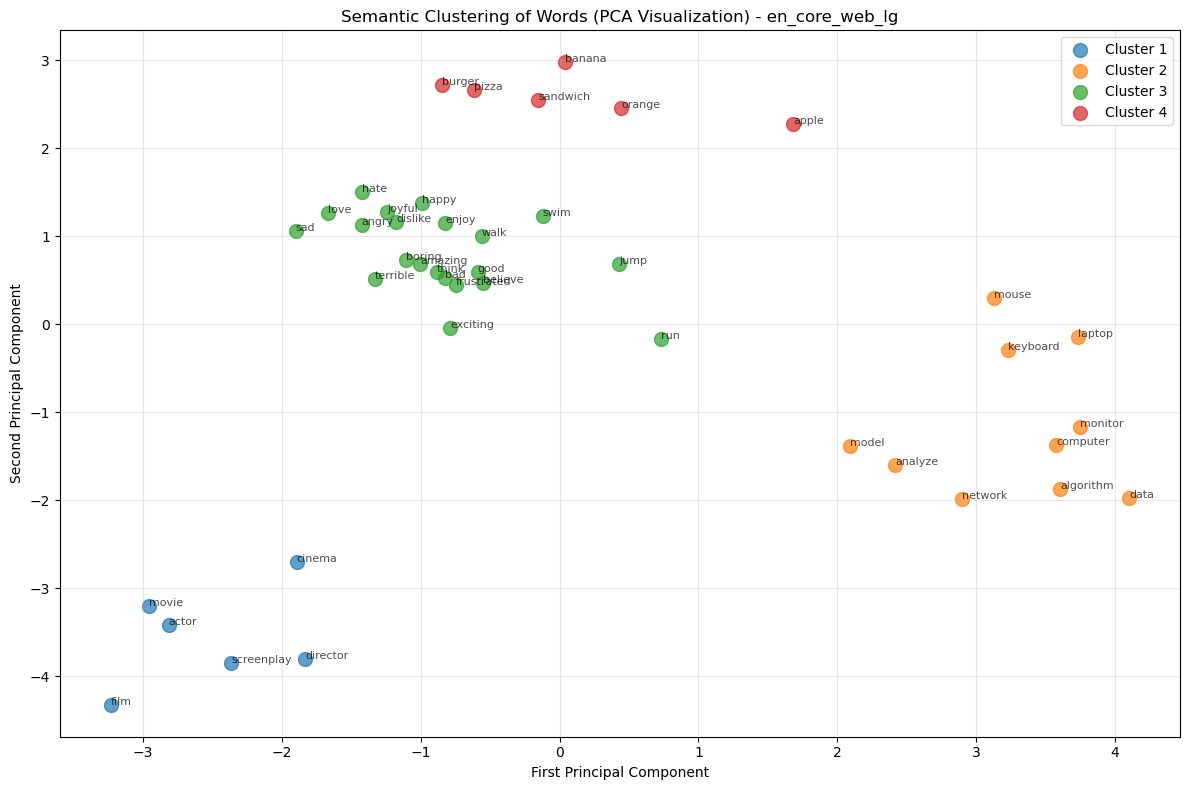


Visualization saved to 'semantic_clusters.png'


In [29]:
# Reduce embeddings to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    cluster_mask = clusters == i
    plt.scatter(
        embeddings_2d[cluster_mask, 0],
        embeddings_2d[cluster_mask, 1],
        label=f'Cluster {i+1}',
        s=100,
        alpha=0.7
    )

# Add word labels
for i, word in enumerate(valid_words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'Semantic Clustering of Words (PCA Visualization) - {MODEL_NAME}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and show the visualization
plt.savefig('semantic_clusters.png', dpi=150)
plt.show()

print("\nVisualization saved to 'semantic_clusters.png'")

## Step 5: Model Comparison and Discussion

Now it’s time to **analyze and discuss your results**.

1. Review the clusters and visualizations you obtained from your experiment.  
2. Take note of specific observations, such as:  
   - Which groups of words make clear sense together?  
   - Which words seem misplaced or ambiguous?  
   - How well the model captures **semantic similarity** (e.g., *movie–film* vs. *cat–dog*).  
3. Record your findings and **share them in the Cascade discussion forums**, summarizing:  
   - What patterns or insights you noticed.  
   - How the clustering differed between models or configurations.  
   - Any unexpected or interesting outcomes.  

After that, **experiment further**:
- Try adjusting the number of clusters.  
- Change or expand your word list.  
- Compare results using different spaCy models (`en_core_web_md` vs. `en_core_web_lg`).  

Reflect on how these changes affect semantic grouping and what this tells you about the strengths and limitations of embedding-based representations.

After experimenting with both models (en_core_web_md and en_core_web_lg), we observed clear differences in how well they grouped the words based on meaning.
## Patterns and Insights
Words with similar meanings were grouped together correctly.
Example clusters:
Movies / film-related → film, movie, cinema, actor, screenplay
Technology → computer, keyboard, monitor, laptop, model, data, network
Food → apple, banana, orange, pizza, burger, sandwich
Emotions / feelings / actions → happy, joyful, sad, angry, love, hate, enjoy, walk, swim, jump

**These clusters make sense in real life — food words stayed together, technology words stayed together, etc.**

## Comparison of models
**en_core_web_md (medium):** Produced reasonable clusters but with some mixing, especially in emotional/action words.

**en_core_web_lg (large):** Gave clearer and tighter grouping. Tech words were far apart from emotional or movie words. Food words were grouped more accurately.

**The large model captured meaning better because it has richer word embeddings.**

## Misplaced or ambiguous words
Some action words like run or swim were grouped with emotions because they often appear with emotional words (e.g., “I enjoy swimming”).
Words like believe or think sometimes appear near emotion or movie clusters; their meaning can overlap with different contexts.
These shifts are normal because semantic embeddings are based on usage in real text.

**Larger models produce better semantic understanding.Smaller models work, but they may mix groups that are weakly related.**

## Final Reflection
The en_core_web_lg model produced more meaningful and cleaner clusters than en_core_web_md. This demonstrates that richer embeddings lead to better semantic grouping. The experiment helped me understand how NLP models represent meaning and why model choice matters.